In [31]:
import requests
import pandas as pd
import json

# Define the API endpoints
endpoints = [
    "http://127.0.0.1:9090/sudo/building-approvals",
     "http://127.0.0.1:9090/sudo/economy-and-industry",
    "http://127.0.0.1:9090/sudo/medians-and-averages"
]

# Fetch data from each endpoint and print the first response
for endpoint in endpoints:
    response = requests.get(endpoint)
    if response.status_code == 200:
        data = response.json()
        if data:
            # Print the first response in an organized JSON format
            print(json.dumps(data[0], indent=4))
        else:
            print(f"No data returned from {endpoint}")
    else:
        print(f"Failed to fetch data from {endpoint}")


{
    " sa4_code": 101,
    "value_tot_resial_building_aud000": 285191.2,
    " value_new_oth_resial_building_aud000": 36028.5,
    " value_new_houses_aud000": 202170.7,
    "yr": 2011,
    " value_tot_building_aud000": "402348.8",
    " sa4_name": "Capital Region"
}
{
    " rsdntl_prprty_prcs_yr_endd_30_jne_hss_mdn_sle_prce": "373500",
    " sa4_code_2016": 101,
    " rsdntl_prprty_prcs_yr_endd_30_jne_attchd_dwllngs_mdn_sle_prce": "254000",
    " sa4_name_2016": "Capital Region",
    " yr": 2014
}
{
    " SA4_NAME11": "Capital Region",
    "yr": 2011,
    " SA4_MAIN11": 101,
    " Median_rent_weekly": 210
}


In [36]:
def standardize_keys(data):
    standardized_data = []
    for item in data:
        standardized_item = {
            "year": item.get("yr") or item.get(" yr"),
            "sa4_code": item.get(" sa4_code") or item.get(" sa4_code_2016") or item.get(" SA4_MAIN11"),
            "sa4_name": item.get("sa4_name") or item.get(" sa4_name") or item.get("sa4_name_2016") or item.get(" SA4_NAME11"),
            "attached_dwelling_median_sale_price": item.get(" rsdntl_prprty_prcs_yr_endd_30_jne_hss_mdn_sle_prce"),
            "house_median_sale_price": item.get(" rsdntl_prprty_prcs_yr_endd_30_jne_attchd_dwllngs_mdn_sle_prce"),
            "total_residential_building_value": item.get("value_tot_resial_building_aud000"),
            "new_other_residential_building_value": item.get(" value_new_oth_resial_building_aud000"),
            "new_houses_value": item.get(" value_new_houses_aud000"),
            "total_building_value": item.get(" value_tot_building_aud000"),
            "median_rent_weekly": item.get(" Median_rent_weekly")
        }
        standardized_data.append(standardized_item)
    return standardized_data


# Fetch data from each endpoint and standardize the keys
all_standardized_data = []
for endpoint in endpoints:
    response = requests.get(endpoint)
    if response.status_code == 200:
        print(f"Fetched data from {endpoint}")
        data = response.json()
        standardized_data = standardize_keys(data)
        all_standardized_data.extend(standardized_data)
    else:
        print(f"Failed to fetch data from {endpoint}")

# Create a single DataFrame from the combined standardized data
result_df = pd.DataFrame(all_standardized_data)

#Since from 2011, the sa4_code 508 is not available and it was split into 2 different regions, 510 and 511.
#We don't have the latitude and longtitude for the sa4_code 508.
#Thus,we remove the rows with sa4_code 508 from the dataframe.
# Drop rows with sa4_code equal to 508
result_df = result_df[result_df['sa4_code'] != 508]

Fetched data from http://127.0.0.1:9090/sudo/building-approvals
Fetched data from http://127.0.0.1:9090/sudo/economy-and-industry
Fetched data from http://127.0.0.1:9090/sudo/medians-and-averages


In [37]:
# Ensure sa4_code is treated as an integer
result_df["sa4_code"] = pd.to_numeric(result_df["sa4_code"], errors="coerce").astype(pd.Int64Dtype())

# Group the data by area and year, and combine the columns using aggregation
result_df = result_df.groupby(["sa4_code", "year"]).agg({
    "sa4_name": "first",
    "attached_dwelling_median_sale_price": "first",
    "house_median_sale_price": "first",
    "total_residential_building_value": "first",
    "new_other_residential_building_value": "first",
    "new_houses_value": "first",
    "total_building_value": "first",
    "median_rent_weekly": "first"
}).reset_index()

In [41]:
#updated version to extract the latitude and logitude from the geometry column
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Load the SA4 region boundaries
geojson_path = "../frontend/SA4_2021_AUST_SHP_GDA2020/SA4_2021_AUST_GDA2020.shp"
gdf = gpd.read_file(geojson_path)

# Remove the non-finite entry
gdf = gdf[gdf['SA4_CODE21'] != 'ZZZ']

# Ensure 'sa4_code' is of integer type in both DataFrames
result_df["sa4_code"] = pd.to_numeric(result_df["sa4_code"], errors="coerce").astype(int)
gdf["SA4_CODE21"] = pd.to_numeric(gdf["SA4_CODE21"], errors="coerce").astype(int)

# Extract 'sa4_code', 'geometry', and 'SA4_NAME21' from the GeoDataFrame and create a dictionary
geometry_dict = {row["SA4_CODE21"]: (row["geometry"], row["SA4_NAME21"]) for _, row in gdf.iterrows()}

# Add the geometry and SA4_NAME21 columns to the DataFrame
result_df["geometry"] = result_df["sa4_code"].map(lambda x: geometry_dict.get(x, (None, None))[0])
result_df["sa4_name"] = result_df["sa4_code"].map(lambda x: geometry_dict.get(x, (None, None))[1])

# Convert the DataFrame to a GeoDataFrame
gdf_combined = gpd.GeoDataFrame(result_df, geometry="geometry")

# Calculate the centroids of the geometries
gdf_combined["centroid"] = gdf_combined.geometry.centroid

# Extract latitude and longitude from the centroids
gdf_combined["latitude"] = gdf_combined.centroid.y
gdf_combined["longitude"] = gdf_combined.centroid.x

# Drop the 'geometry' and 'centroid' columns
df_with_lat_lon = gdf_combined.drop(columns=["geometry", "centroid"])

# Save to a CSV file to make final table
csv_path = "combined_data_with_lat_lon_updated.csv"
df_with_lat_lon.to_csv(csv_path, index=False)
print(f"Combined data with latitude and longitude has been saved to '{csv_path}'")

Combined data with latitude and longitude has been saved to 'combined_data_with_lat_lon_updated.csv'


In [44]:
import pandas as pd
# Load data with latitude and longitude
result_df = pd.read_csv("combined_data_with_lat_lon_updated.csv")


In [48]:
#Smaller verison of the data focusing on Sydney and Melbourne
# Filter the data to include only Sydney and Melbourne
result_df = result_df[result_df["sa4_name"].isin(["Sydney - City and Inner South", "Sydney - Inner West", "Sydney - Eastern Suburbs", "Sydney - North Sydney and Hornsby", "Sydney - Northern Beaches", "Sydney - Ryde", "Sydney - Strathfield", "Sydney - Sutherland", "Melbourne - Inner", "Melbourne - Inner East", "Melbourne - Inner South", "Melbourne - North East", "Melbourne - North West", "Melbourne - Outer East", "Melbourne - South East", "Melbourne - West"])]
# Save the filtered data to a CSV file
csv_path = "sydney_melbourne_data.csv"
result_df.to_csv(csv_path, index=False)
print(f"Sydney and Melbourne data has been saved to '{csv_path}'")

Sydney and Melbourne data has been saved to 'sydney_melbourne_data.csv'


In [51]:
#visualise heatmap
import pandas as pd
import folium
from folium.plugins import HeatMap
from IPython.display import IFrame

# Create a base map centered on Australia
australia_center = [-25.2744, 133.7751]  # Latitude and longitude of the center of Australia
m = folium.Map(location=australia_center, zoom_start=4, tiles='OpenStreetMap')

# Define the column names for the housing prices
price_columns = [
    'attached_dwelling_median_sale_price',
    'house_median_sale_price',
    'total_residential_building_value',
    'new_other_residential_building_value',
    'new_houses_value',
    'total_building_value',
    'median_rent_weekly'
]

# Custom color gradient
gradient = {0.0: 'blue', 0.2: 'cyan', 0.4: 'lime', 0.6: 'yellow', 0.8: 'orange', 1.0: 'red'}


# Create a heatmap for each price column and year
for column in price_columns:
    for year in result_df['year'].unique():
        # Filter the data for the current year and column
        data = result_df[(result_df['year'] == year) & (result_df[column].notnull())]
        
        # Ensure there are no NaN values in latitude and longitude
        data = data.dropna(subset=['latitude', 'longitude'])
        
        # Extract the latitude, longitude, and price values
        heatmap_data = data[['latitude', 'longitude', column]].values.tolist()
        
        if not heatmap_data:
            continue  # Skip if there's no data for the heatmap
        
        # Create a heatmap layer
        heatmap = HeatMap(heatmap_data, name=f"{column} ({year})", radius=15, blur=15, max_zoom=18, gradient= gradient)
        
        # Add the heatmap layer to the map
        heatmap.add_to(m)

# Add the layer control to the map
folium.LayerControl(position='topright', collapsed=False).add_to(m)

# Save the map to an HTML file
map_filename = "output/heatmap-sydney-melbourne.html"
m.save(map_filename)

print(f"Heatmap has been saved to '{map_filename}'")

# Display the map in a Jupyter notebook?? #<IPython.lib.display.IFrame at 0x15b74a980>
display(IFrame(map_filename, width=800, height=600))


Heatmap has been saved to 'output/heatmap-sydney-melbourne.html'


Plot has been saved to 'output/total_residential_building_value_plot.html'
Plot has been saved to 'output/attached_dwelling_median_sale_price_plot.html'
Plot has been saved to 'output/house_median_sale_price_plot.html'
Plot has been saved to 'output/new_other_residential_building_value_plot.html'
Plot has been saved to 'output/new_houses_value_plot.html'
Plot has been saved to 'output/total_building_value_plot.html'
Plot has been saved to 'output/median_rent_weekly_plot.html'


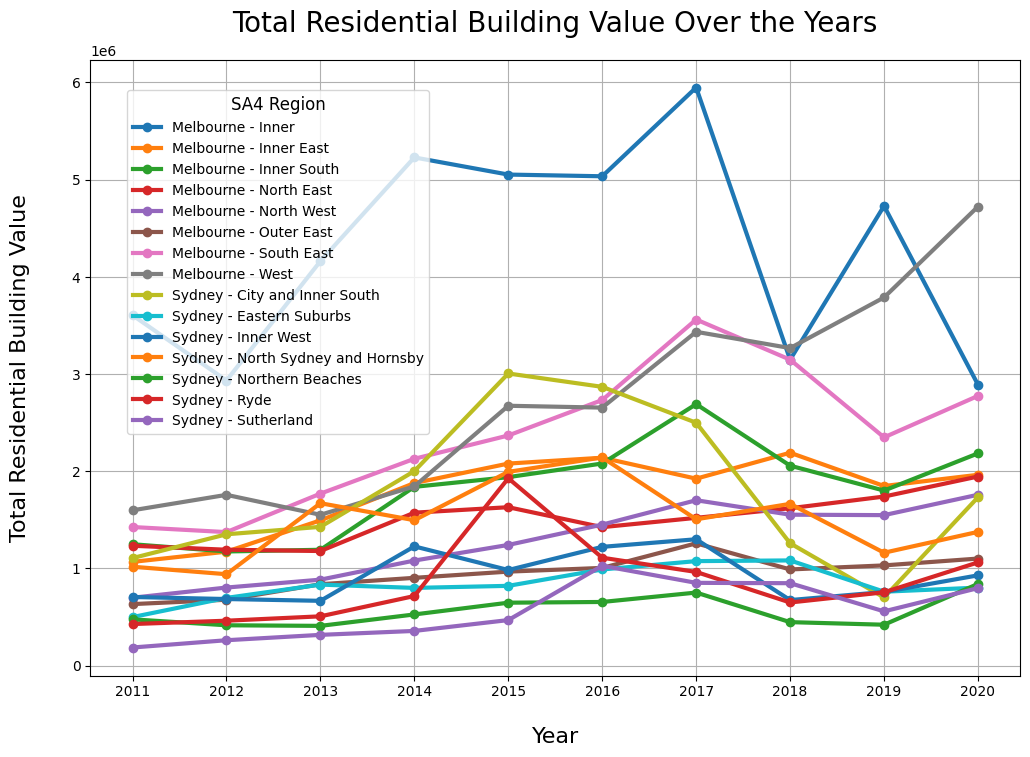

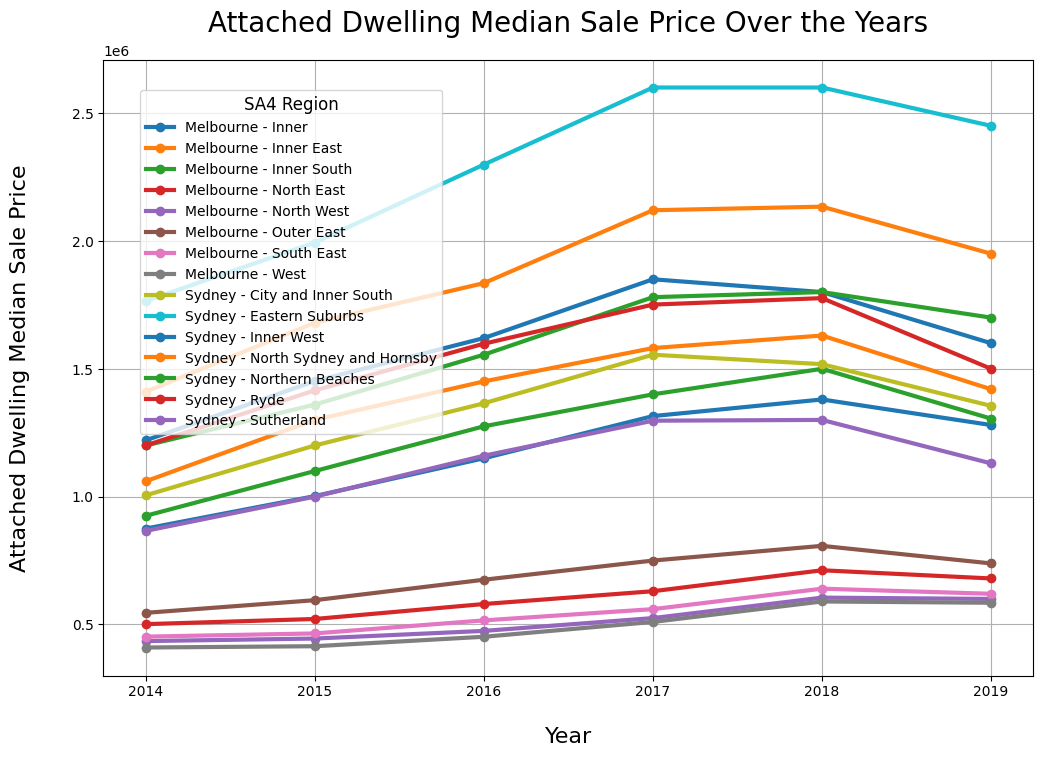

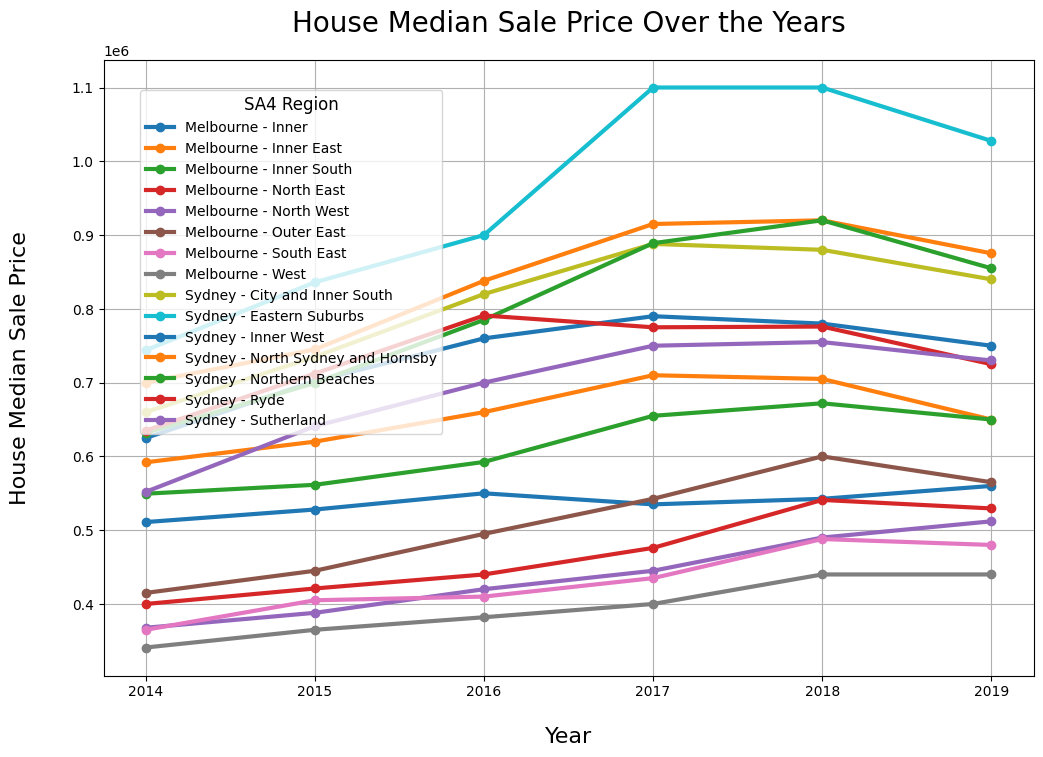

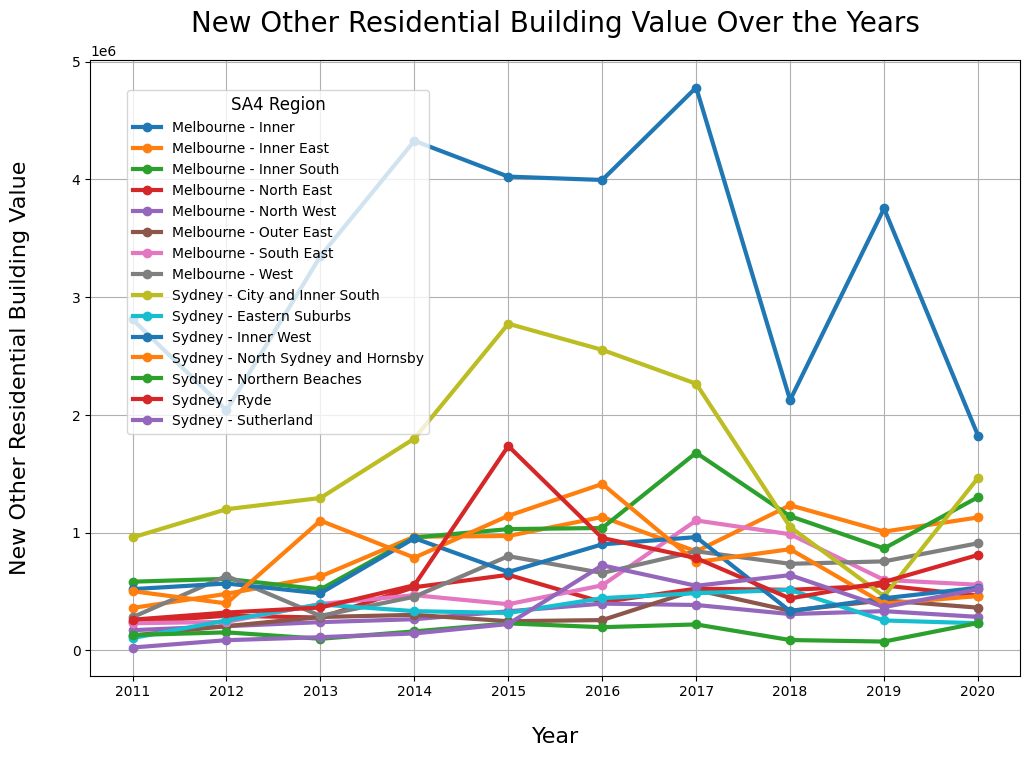

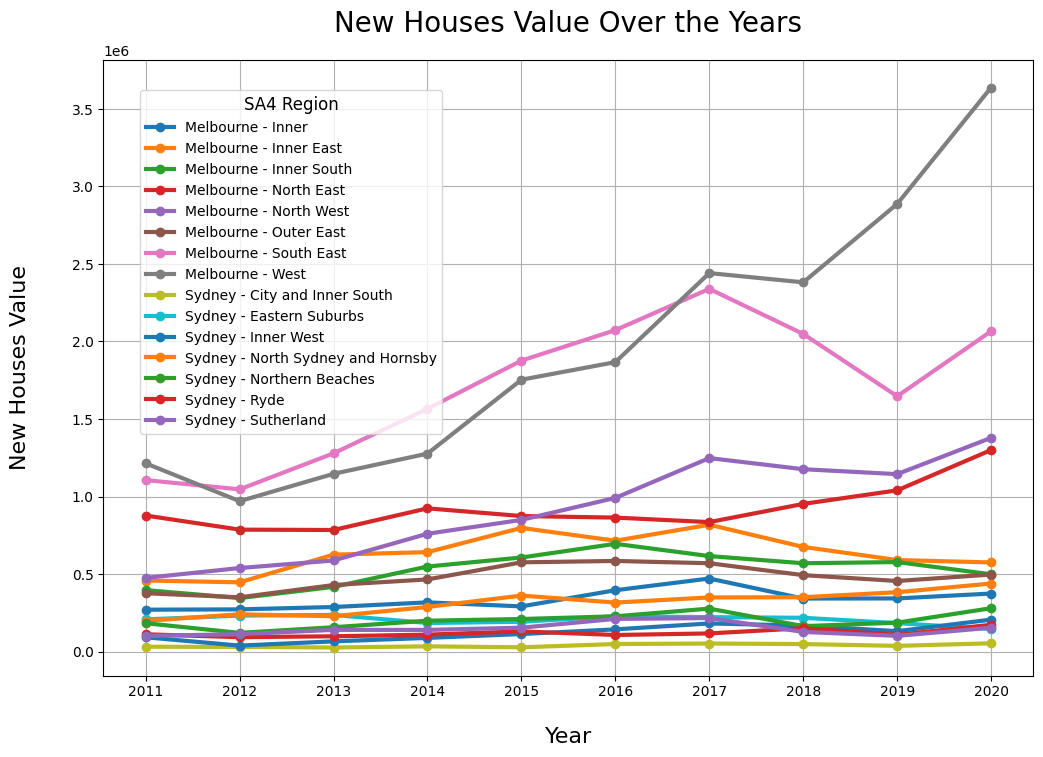

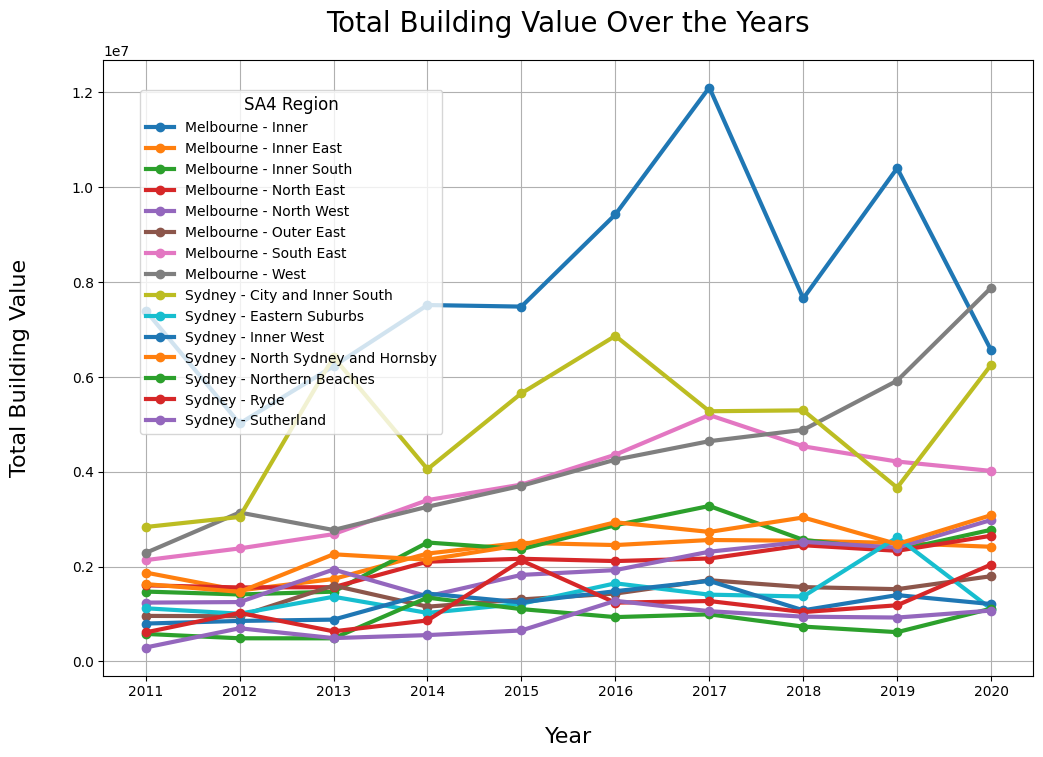

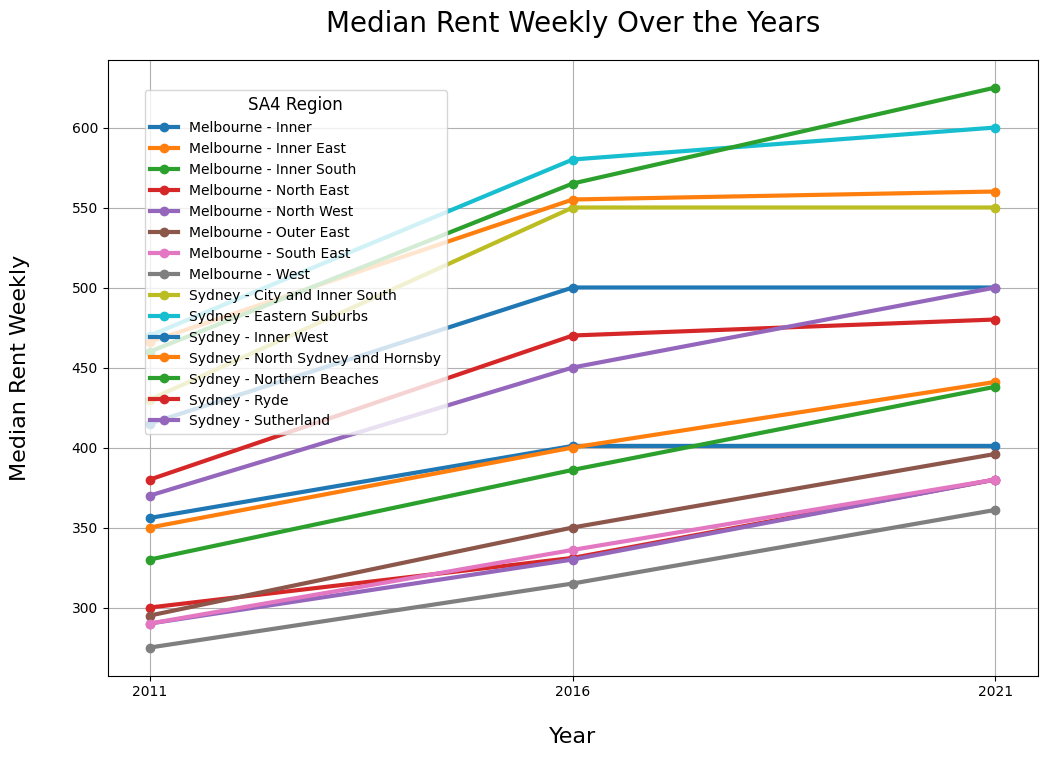

In [55]:
#generate line graph (x: year, y: price, line: sa4_name)
import pandas as pd
import matplotlib.pyplot as plt
import mpld3
import seaborn as sns

# Load data from the CSV file
# All data
#result_df = pd.read_csv("combined_data_with_lat_lon_updated.csv")

# Sydney and Melbourne data
result_df = pd.read_csv("sydney_melbourne_data.csv")

# Function to plot housing prices for a selected price column and save as HTML
#def plot_housing_prices(price_column, output_html, top_n):
def plot_housing_prices(price_column, output_html):
    
    # Filter the data to keep only the rows where the selected price column is not null
    data = result_df.dropna(subset=[price_column])
    
    # Check if the filtered data is empty
    if data.empty:
        print(f"No data available for {price_column}")
        return
    
    # Pivot the data to get years as rows and sa4_names as columns
    pivot_df = data.pivot(index='year', columns='sa4_name', values=price_column)
    
    # Check if pivoted data is empty
    if pivot_df.empty:
        print(f"No data available for {price_column} after pivoting")
        return
    
    # # Select the top N regions with the highest mean values
    # top_regions = pivot_df.mean().sort_values(ascending=False).head(top_n).index
    # pivot_df = pivot_df[top_regions]
    
    # Plot the line graph
    fig, ax = plt.subplots(figsize=(12, 8))
    color_palette = sns.color_palette("tab10", len(pivot_df.columns))

    for color, column in zip(color_palette, pivot_df.columns):
        ax.plot(pivot_df.index, pivot_df[column], label=column, linewidth=3, marker='o', markersize=6, color=color)
    
    # Add labels and title
    ax.set_xlabel('Year', fontsize=16, labelpad=20)
    ax.set_ylabel(price_column.replace('_', ' ').title(), fontsize=16, labelpad=30)
    ax.set_title(f'{price_column.replace("_", " ").title()} Over the Years', fontsize=20, pad=20)
    
    # Add legend only if there are labels, bbox_to_anchor=(0.15, 0.96)
    if pivot_df.columns.size > 0:
        ax.legend(title='SA4 Region', bbox_to_anchor=(0.15, 0.85), loc='upper left', fontsize='medium', title_fontsize='large', bbox_transform=fig.transFigure)
    
    ax.grid(True)

    # Set the x-axis ticks to display only unique years
    ax.set_xticks(sorted(data['year'].unique()))
    ax.set_xticklabels(sorted(data['year'].unique(),key=int))

    # Save the plot as an HTML file using mpld3
    mpld3.save_html(fig, output_html)
    print(f"Plot has been saved to '{output_html}'")

#usage
plot_housing_prices('total_residential_building_value', 'output/total_residential_building_value_plot.html') #okay
plot_housing_prices('attached_dwelling_median_sale_price', 'output/attached_dwelling_median_sale_price_plot.html') #okay
plot_housing_prices('house_median_sale_price', 'output/house_median_sale_price_plot.html') #okay
plot_housing_prices('new_other_residential_building_value', 'output/new_other_residential_building_value_plot.html') #okay
plot_housing_prices('new_houses_value', 'output/new_houses_value_plot.html') #okay
plot_housing_prices('total_building_value', 'output/total_building_value_plot.html') #okay
plot_housing_prices('median_rent_weekly', 'output/median_rent_weekly_plot.html') #okay


In [62]:
#generate line graph (x: year, y: price, line: sa4_name)
import pandas as pd
import matplotlib.pyplot as plt
import mpld3
import seaborn as sns

# Load data from the CSV file
# All data
#result_df = pd.read_csv("combined_data_with_lat_lon_updated.csv")

MEL_SYD_SA4_NAME_DICT = {
    'Sydney - Outer South West': 123,
    'Sydney - Inner West': 120,
    'Sydney - Inner South West': 119,
    'Sydney - Eastern Suburbs': 118,
    'Sydney - City and Inner South': 117,
    'Sydney - Blacktown': 116,
    'Sydney - North Sydney and Hornsby': 121,
    'Sydney - Sutherland': 128,
    'Sydney - South West': 127,
    'Melbourne - South East': 212,
    'Melbourne - Outer East': 211,
    'Melbourne - North West': 210,
    'Melbourne - North East': 209,
    'Melbourne - Inner South': 208,
    'Melbourne - Inner East': 207,
    'Melbourne - Inner': 206
}

df_sudo_major = df_sudo[df_sudo.apply(lambda x: x['SA4 Code'] in MEL_SYD_SA4_NAME_DICT.values(), axis=1)]

fig = px.line(df_sudo_major, x="Year", y='Median rent weekly', color='SA4 Code', 
              title='Median Weekly Rent by SA4 Code Over Years')

# Moving the legend to the right of the plot and making it interactive
fig.update_layout(
    legend=dict(
        title='SA4 Code',
        orientation="v",
        yanchor="middle",
        y=0.5,
        xanchor="right",
        x=1.05
    )
)

fig.show()

SyntaxError: invalid syntax (2446389904.py, line 11)